In [111]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [112]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [113]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [122]:
### Read measurements
#### The annotation file has been edited to reflect decreasing intracellular Asp conc.
#### as a function of media Asp. It appears that David used the wrong tubes when transfering extract.
annotation_df = pd.read_excel('annotation_df.xlsx')
#annotation_df = pd.read_excel('annotation_df_old.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('HT1080-2xGOT-KO_Asp-titration.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [123]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values

In [124]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['Pyr-Lac'] = (df['Pyruvate neg'] / df['Lactate neg']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

In [125]:
df_mean = df.groupby(['Aspartate_media', 'Treatment']).mean().reset_index()
df_stdev = df.groupby(['Aspartate_media', 'Treatment']).std().reset_index()
df_stdev['Prlfr'] = df_mean['Prlfr_stdev']

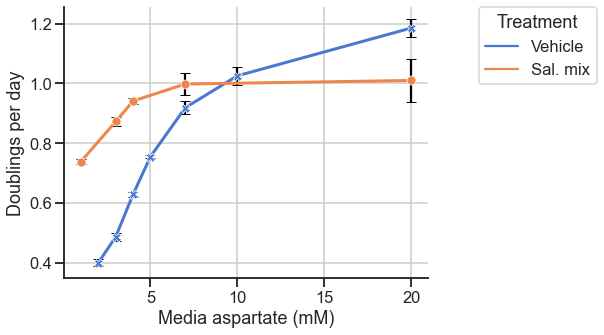

In [119]:
### Proliferation as a function of media Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate_media', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean['Prlfr'].values, x=df_mean['Aspartate_media'].values, yerr=df_stdev['Prlfr'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Media aspartate (mM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Prlfr-media-Aspartate.pdf', bbox_inches='tight')

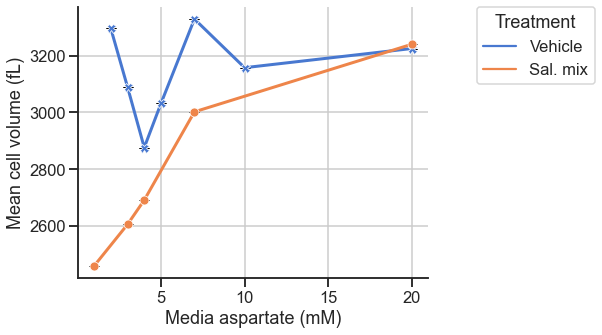

In [120]:
### Cell volume as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate_media', y='Cell_vol', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean['Cell_vol'].values, x=df_mean['Aspartate_media'].values, yerr=df_stdev['Cell_vol'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Media aspartate (mM)')
g1.set_ylabel('Mean cell volume (fL)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Cell-vol-media-Aspartate.pdf', bbox_inches='tight')

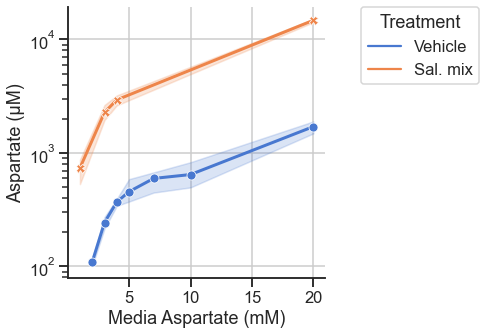

In [126]:
### Aspartate as a function of Metformin ###

fig, ax1 = plt.subplots(1, 1, figsize=(7.4, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df[mask], x='Aspartate_media', y='Aspartate conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.set(yscale="log")

g1.set_xlabel('Media Aspartate (mM)')
g1.set_ylabel('Aspartate (μM)')
#g1.set(ylim=(230, 1300))

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Metformin-Aspartate.pdf', bbox_inches='tight')

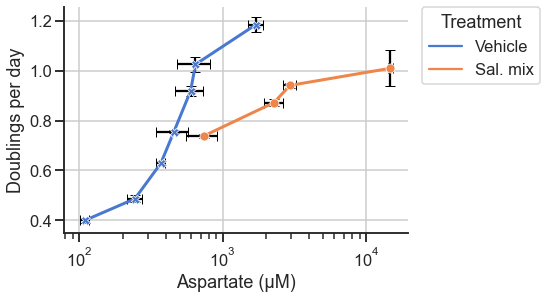

In [127]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

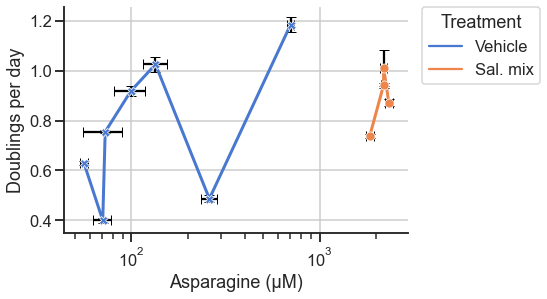

In [128]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Asparagine conc', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Asparagine conc'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Asparagine conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Asparagine (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

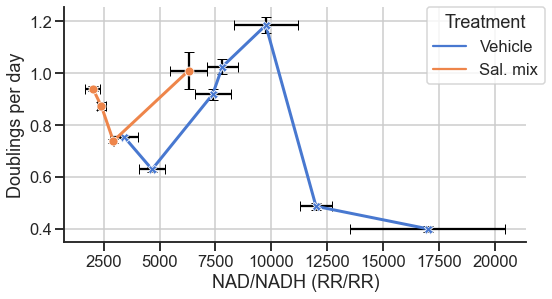

In [129]:
### Proliferation as a function of NAD/NADH ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['NAD-NADH'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=1)


g1.set_xlabel('NAD/NADH (RR/RR)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/NAD-NADH-Prlfr.pdf', bbox_inches='tight')

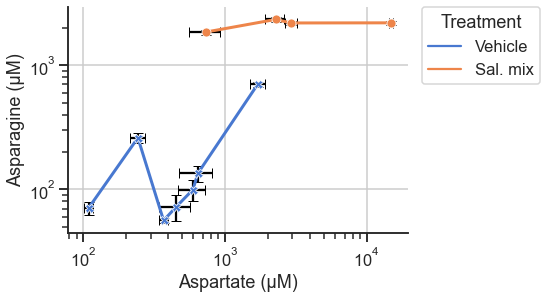

In [130]:
### Asparagine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Asparagine conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Asparagine conc'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Asparagine conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")
g1.set(yscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Asparagine (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Asparagine.pdf', bbox_inches='tight')

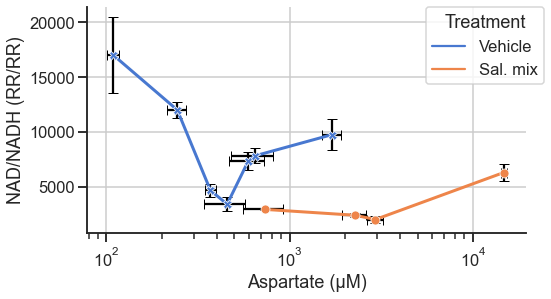

In [131]:
### NAD/NADH as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='NAD-NADH', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['NAD-NADH'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['NAD-NADH'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('NAD/NADH (RR/RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-NAD-NADH.pdf', bbox_inches='tight')

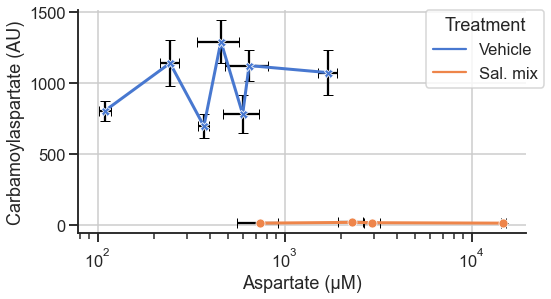

In [132]:
### Carbamoylaspartate as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Carbamoylaspartate neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Carbamoylaspartate neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Carbamoylaspartate neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Carbamoylaspartate (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-Carbamoylaspartate.pdf', bbox_inches='tight')

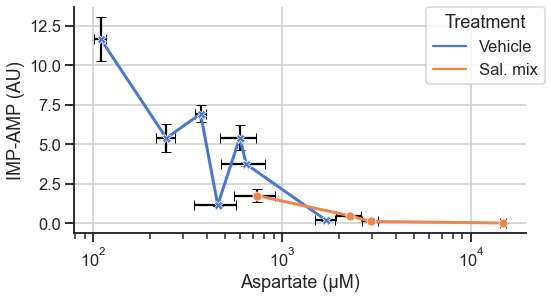

In [133]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='IMP-AMP', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['IMP-AMP'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['IMP-AMP'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set(xscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP-AMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')

In [70]:
metab_names_mes

['3-Phosphoglycerate neg',
 'Adenosine pos',
 'Alanine pos',
 'alpha-Ketoglutarate neg',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'Carbamoylaspartate neg',
 'CMP neg',
 'Cytidine pos',
 'DHAP neg',
 'Fumarate neg',
 'Glucose 6-phosphate neg',
 'Glutamate neg',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'GMP pos',
 'Hypoxanthine pos',
 'IMP pos',
 'Lactate neg',
 'Malate neg',
 'Metformin pos',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phosphoenolpyruvate neg',
 'Proline pos',
 'SAICAR neg',
 'SAICAR pos',
 'Serine neg',
 'Succinate neg',
 'UMP neg',
 'Uridine neg',
 'Xanthine neg']